## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2021.

# Assignment 1, Task 3: Multilayer Perceptron (MLP)
This is the third part of the assignment. You will get to implement MLP using tensorflow

In [4]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [35]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Tensorflow MLP
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net, of which style is referred to https://www.tensorflow.org/guide/keras, and https://www.tensorflow.org/guide/eager. 

You need to implement a multi-layer with 3 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [5]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b2 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 12
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.7329999804496765
epoch 2: valid acc = 0.7850000262260437
epoch 3: valid acc = 0.8180000185966492
epoch 4: valid acc = 0.8399999737739563
epoch 5: valid acc = 0.8489999771118164
epoch 6: valid acc = 0.8550000190734863
epoch 7: valid acc = 0.8560000061988831
epoch 8: valid acc = 0.8610000014305115
epoch 9: valid acc = 0.8640000224113464
epoch 10: valid acc = 0.8659999966621399
epoch 11: valid acc = 0.8700000047683716
epoch 12: valid acc = 0.8709999918937683
test acc = 0.8557999730110168


### Create Deeper Network

<span style="color:red"><strong>TODO</strong></span>: Create your MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" to store your network parameters (weights and bias). Consider using a loop to create your MLP network. Hint: Copy the above code and make necessary changes in model definition.

<span style="color:red"><strong>Solution</strong></span>:

In [10]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = [300,300]
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim[0]).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim[0],)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim[0], hidden_dim[1]).astype('float32'))
        self.b2 = tf.Variable(np.zeros((hidden_dim[1],)).astype('float32'))
        self.W3 = tf.Variable(1e-2*np.random.rand(hidden_dim[1], 20).astype('float32'))
        self.b3 = tf.Variable(np.zeros((20,)).astype('float32'))
    
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        h2 = tf.nn.relu(tf.matmul(h1, self.W2) + self.b2)
        out = tf.matmul(h2, self.W3) + self.b3
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)+tf.nn.l2_loss(model.W3)
    
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2, model.W3, model.b3])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 12
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2, model.W3, model.b3]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.2540000081062317
epoch 2: valid acc = 0.289000004529953
epoch 3: valid acc = 0.28700000047683716
epoch 4: valid acc = 0.4300000071525574
epoch 5: valid acc = 0.4320000112056732
epoch 6: valid acc = 0.4740000069141388
epoch 7: valid acc = 0.5649999976158142
epoch 8: valid acc = 0.6019999980926514
epoch 9: valid acc = 0.6290000081062317
epoch 10: valid acc = 0.6499999761581421
epoch 11: valid acc = 0.6639999747276306
epoch 12: valid acc = 0.6800000071525574
test acc = 0.675599992275238


### Introduction to TensorFlow.keras

As you can see, when the network structure becomes larger, it is hard to handle variables from every layer. Here we introduce the `tf.keras` tool to build the network in a much simpler way. You may want to use it in your project.

<span style="color:red"><strong>TODO</strong></span>: Follow this official example: https://www.tensorflow.org/datasets/keras_example#step_2_create_and_train_the_model to build an MLP and train it. 

*You should keep the same optimizer (SGD) and loss function (cross entropy) as in the previous task.*

**Note:** Since we want to use our own dataset, we will not use the `tfds.load` method to load the data this time. 

You need to check the usage of [`model.fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) and feed the model with our own data.

**Tips:**
* Softmax is also registered as a layer operation in tf.keras.
* You can use `model.summary()` to visualize the model after you build it.
* Use `verbose=2` in `model.fit()` to get similar training logs

<span style="color:red"><strong>SOLUTION</strong></span>:

In [36]:
#############################################################
# TODO: build the model with tf.keras.models.Sequential
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28)),
  tf.keras.layers.Dense(300,activation='relu'),
  tf.keras.layers.Dense(10)
])
# END of your code
#############################################################

#############################################################
# TODO: compile the model, set optimizer and loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# END of your code
#############################################################

#############################################################
# TODO: train the model with our own dataset
model.fit(
    #num_training=49000
    x=X_train_raw[:num_training, :], 
    y=y_train,
    epochs=12,
    validation_data=test,
)
model.summary()
# END of your code
#############################################################
#tf.keras.layers.Flatten(
#    data_format=None, **kwargs
#)
#############################################################
#tf.keras.layers.Dense(
#    units, activation=None, use_bias=True,
#    kernel_initializer='glorot_uniform',
#    bias_initializer='zeros', kernel_regularizer=None,
#    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
#    bias_constraint=None, **kwargs
#)
#units	Positive integer, dimensionality of the output space.
#############################################################
#fit(
#    x=None, y=None, batch_size=None, epochs=1, verbose='auto',
#   callbacks=None, validation_split=0.0, validation_data=None, shuffle=True,
#    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
#    validation_steps=None, validation_batch_size=None, validation_freq=1,
#    max_queue_size=10, workers=1, use_multiprocessing=False
#)
#############################################################

Epoch 1/12
1532/1532 [==============================] - 4s 2ms/step - loss: 15.7701 - sparse_categorical_accuracy: 0.6990 - val_loss: 0.6908 - val_sparse_categorical_accuracy: 0.7696
Epoch 2/12
1532/1532 [==============================] - 3s 2ms/step - loss: 0.6238 - sparse_categorical_accuracy: 0.7849 - val_loss: 0.6049 - val_sparse_categorical_accuracy: 0.8045
Epoch 3/12
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5283 - sparse_categorical_accuracy: 0.8196 - val_loss: 0.5978 - val_sparse_categorical_accuracy: 0.8060
Epoch 4/12
1532/1532 [==============================] - 3s 2ms/step - loss: 0.4973 - sparse_categorical_accuracy: 0.8314 - val_loss: 0.5024 - val_sparse_categorical_accuracy: 0.8336
Epoch 5/12
1532/1532 [==============================] - 3s 2ms/step - loss: 0.4919 - sparse_categorical_accuracy: 0.8363 - val_loss: 0.5491 - val_sparse_categorical_accuracy: 0.8182
Epoch 6/12
1532/1532 [==============================] - 3s 2ms/step - loss: 0.4678 - spar

## Part 2: t-SNE (optional, bonus +5 points)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR100. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [1]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP
from utils.features.tsne import tsne

In [5]:
# Load the raw Fashion-MNIST data.
train_data, test_data = fashion_mnist.load_data()

X_train_raw, y_train = train_data
X_test_raw, y_test = test_data

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


#### tSNE of original data

In [6]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test_raw[random_select,:,:].reshape(500,X_train.shape[1]).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

2.924629616009461
The 100 th loop cost: 11.570412180798328, computation time: 1.7936375141143799
The 200 th loop cost: 0.5201162406204886, computation time: 3.530355453491211
The 300 th loop cost: 0.49427951763246314, computation time: 5.257779598236084
The 400 th loop cost: 0.4907120624872888, computation time: 7.000722885131836
The 500 th loop cost: 0.49012095279923024, computation time: 8.748710632324219
The 600 th loop cost: 0.48995821048114757, computation time: 10.508992195129395
The 700 th loop cost: 0.4899029286541808, computation time: 12.202234745025635
The 800 th loop cost: 0.48988221522670705, computation time: 13.94223666191101
The 900 th loop cost: 0.4898741320057649, computation time: 15.660705804824829
The 1000 th loop cost: 0.4898708534688544, computation time: 17.295448780059814
it takes 17.93761420249939 seconds


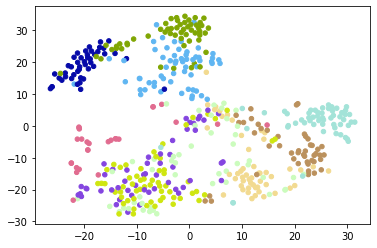

In [8]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

Do visualization of the tSNE of data after going through MLP. In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, tSNE of data after two-layer networks would be shown as multiple clusters in a 2D panel.

In [10]:
# Define MLP model
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100], num_classes=10, reg=0.1, weight_scale=1e-3)
num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 245
epoch 1: valid acc = 0.803, new learning rate = 0.00095
epoch 2: valid acc = 0.84, new learning rate = 0.0009025
epoch 3: valid acc = 0.858, new learning rate = 0.000857375
epoch 4: valid acc = 0.853, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.868, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.873, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.878, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.875, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.874, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.88, new learning rate = 0.0005987369392383785
test acc: 0.8646


0.8646

<span style="color:red"><strong>TODO</strong></span>: Visualize data that is passed through MLP model defined above using tSNE. 

In [36]:
# run tSNE
X = X_test[random_select] # random_select = np.random.choice(10000, 500, replace=False)
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################

# run tSNE

X = model.layers[0].feedforward(X)# Hint: Pass data through affine and dense layers (model.layers)
X = model.layers[1].feedforward(X)

X = np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True) # Apply softmax to obtain output of the MLP model.

tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

0.1475934854530945
The 100 th loop cost: 8.30080250957258, computation time: 1.6919996738433838
The 200 th loop cost: 0.21068534706456962, computation time: 3.4023895263671875
The 300 th loop cost: 0.18174886771087573, computation time: 5.147501707077026
The 400 th loop cost: 0.1728855127256206, computation time: 6.974909782409668
The 500 th loop cost: 0.16930636460895274, computation time: 8.809253215789795
The 600 th loop cost: 0.16724434142245462, computation time: 10.417839527130127
The 700 th loop cost: 0.16587431191630062, computation time: 12.031775712966919
The 800 th loop cost: 0.16491192365155327, computation time: 13.772324800491333
The 900 th loop cost: 0.16417265325310343, computation time: 15.441188335418701
The 1000 th loop cost: 0.16359072727628005, computation time: 17.061733722686768
it takes 17.718703985214233 seconds


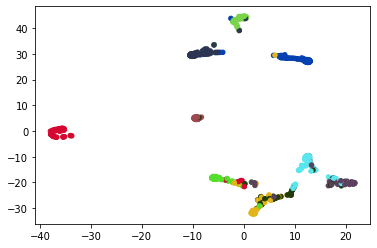

In [37]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
# Hint: See tSNE visualization of original data
#############################################################################

labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of tSNE, do visualization of the new tSNE of data.

In [34]:
# Tune the parameter, show the results.
# run tSNE
X = X_test[random_select]

#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################
X = model.layers[0].feedforward(X)# Hint: Pass data through affine and dense layers (model.layers)
X = model.layers[1].feedforward(X)

X = np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)# apply softmax to obtain output of the MLP model.

tic = time.time()
Y = tsne(X, low_dim=2, perplexity=10.0)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

0.059456068001918085
The 100 th loop cost: 10.668234126713791, computation time: 1.743377923965454
The 200 th loop cost: 0.39496493500324015, computation time: 3.5427725315093994
The 300 th loop cost: 0.2855356631895204, computation time: 5.1405863761901855
The 400 th loop cost: 0.24819845403716784, computation time: 6.786922216415405
The 500 th loop cost: 0.23350849082524877, computation time: 8.4104163646698
The 600 th loop cost: 0.2250575413928131, computation time: 10.15221905708313
The 700 th loop cost: 0.21899641032393918, computation time: 11.937846422195435
The 800 th loop cost: 0.21407774706007804, computation time: 13.582893371582031
The 900 th loop cost: 0.21067856731165968, computation time: 15.242861032485962
The 1000 th loop cost: 0.2083396801453065, computation time: 16.947922229766846
it takes 17.802568674087524 seconds


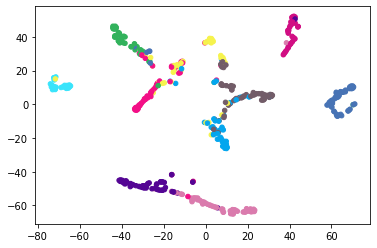

In [35]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################